# Task 3 - Grad-CAM

In [1]:
import torch.nn as nn
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import os
from PIL import Image

In [2]:
conv1_features = 8
conv2_features = 16

class ThreeLayerCNN(nn.Module): # objects map image tensors to logits (confidence scores for predicted digit)
    def __init__(self):
        super(ThreeLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, conv1_features, kernel_size=5, padding="same") # (input channels, output channels ie kernels applied, .., ..); padding keeps spatial size the same
        self.relu1 = nn.ReLU() # non-linear activation function - ReLU(a) = max(a,0);
        self.pool1 = nn.MaxPool2d(2) # downsampling 28x28 -> 14x14
        self.conv2 = nn.Conv2d(conv1_features, conv2_features, kernel_size=5, padding="same") # another conv, 4 channels from prev layer, 8 produced here
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2) # 14x14->7x7

        # 3 fully-connected layers (MLP head)
        self.fc1 = nn.Linear(conv2_features * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu_fc = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # flatten to (N, conv2_features*7*7)
        x = self.relu_fc(self.fc1(x))
        x = self.relu_fc(self.fc2(x))
        x = self.fc3(x)  # logits
        return x
model = ThreeLayerCNN()


# load weights into the model:
state_dict = torch.load("../task1/saved_models/cnn_weights_feb1_GODLYPULL.pth")
model.load_state_dict(state_dict)
model.eval()  # set to eval mode
model.to("cpu")  # move to CPU

ThreeLayerCNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu_fc): ReLU()
)

In [12]:
BASE_TRANSFORM = transforms.ToTensor()

def preprocess_image(img_path):
    """Load and preprocess an image."""
    img = Image.open(img_path).convert('RGB')
    img_tensor = BASE_TRANSFORM(img) # should convert from 0-255 RGB to 0-1 CHW tensor
    # pytorch moels expect a batch dimension - set to 1 since we are passing one image here
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    return img, img_tensor

def get_class_labl(prediction_tensor):
    """Get the predicted class label from model output tensor."""
    # prediction tensor shape: (1, 10) for batch size 1, telling torch to get max along dim 1
    _, predicted_idx = torch.max(prediction_tensor, 1)
    return predicted_idx.item() # converting from tensor to integer

def get_conv_layer(model, layer_name):
    """Retrieve a convolutional layer from the model by name."""
    # network is stored as a tree of objects
    # named modules returns (name, module) pairs for all modules in the network e.g. ('conv2',Conv2d(...))
    return dict([*model.named_modules()])[layer_name]

img, img_tensor = preprocess_image("../task0/outputs/colored-mnist/train/images/00001_0.png")
img_tensor.to("cpu")

tensor([[[[0.4784, 0.6941, 0.7020,  ..., 0.6118, 0.5843, 0.6588],
          [0.7333, 0.6510, 0.5725,  ..., 0.7804, 0.6314, 0.6627],
          [0.8275, 0.6745, 0.8157,  ..., 0.5725, 0.7294, 0.7647],
          ...,
          [0.7882, 0.7843, 0.7490,  ..., 0.6196, 0.6667, 0.7922],
          [0.6667, 0.5843, 0.5412,  ..., 0.6471, 0.4902, 0.8078],
          [0.5725, 0.5804, 0.7569,  ..., 0.7333, 0.7922, 0.5137]],

         [[0.2471, 0.2235, 0.1608,  ..., 0.3686, 0.1647, 0.4980],
          [0.1922, 0.1961, 0.4980,  ..., 0.4157, 0.3922, 0.3137],
          [0.2941, 0.1922, 0.2275,  ..., 0.1569, 0.2745, 0.2314],
          ...,
          [0.3882, 0.4000, 0.3098,  ..., 0.2667, 0.3451, 0.4000],
          [0.2745, 0.1569, 0.3098,  ..., 0.4902, 0.2353, 0.2941],
          [0.3647, 0.2863, 0.2588,  ..., 0.3961, 0.4353, 0.4235]],

         [[0.2941, 0.2824, 0.3529,  ..., 0.1961, 0.3098, 0.3451],
          [0.3059, 0.3451, 0.3020,  ..., 0.3137, 0.3137, 0.4588],
          [0.3922, 0.2706, 0.3294,  ..., 0

In [4]:
# Dictionary to store activations (feature maps of conv2 layer)
activations = []
gradients = []

# Function to save gradients
def save_gradient(module, grad_in, grad_out):
    gradients.append(grad_out[0].cpu().numpy().squeeze())

# Function to save activations
def save_activations(module, input, output):
    activations.append(output.detach().cpu().numpy().squeeze())
    # should have 16 feature maps of size 14x14 (since before max pooling)

model.zero_grad()

# Attach the hooks to the last convolutional layer
last_conv_layer = get_conv_layer(model, 'conv2')

activations_hook = last_conv_layer.register_forward_hook(save_activations)
gradients_hook = last_conv_layer.register_full_backward_hook(save_gradient)


# Forward pass through the model to get activations
prediction = model(img_tensor)

# Backward pass to get gradients
score = prediction[0].max()
score.backward()

# Remove hooks
activations_hook.remove()
gradients_hook.remove()

activations_shape = np.shape(activations[0])
print(f"Shape of activations: {activations_shape}") # (512, 14, 14)

gradients_shape = np.shape(gradients[0])
print(f"Shape of gradients: {gradients_shape}") # (512, 14, 14)


Shape of activations: (16, 14, 14)
Shape of gradients: (16, 14, 14)


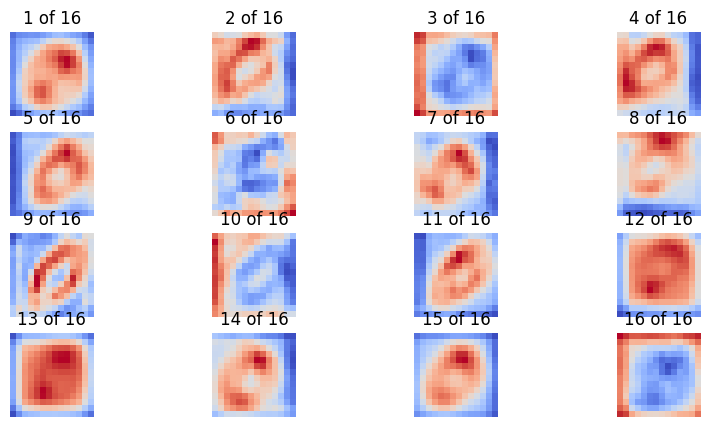

In [5]:
# Plot the activations
fig, ax = plt.subplots(4, 4, figsize=(10, 5))
ax = ax.flatten()

for i, activation in enumerate(activations[0][0:16]):  # Plot first 16 feature maps

    ax[i].imshow(activation, cmap="coolwarm")
    ax[i].set_title(f"{i+1} of {activations_shape[0]}")
    ax[i].axis("off")


## Creating the Grad-CAM Visualizations

Text(0, 0.5, 'Frequency')

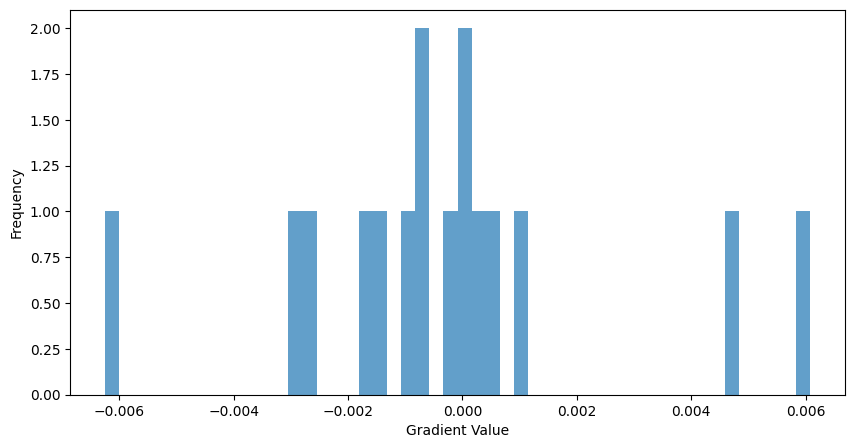

In [6]:
# Step 1: aggregate the gradients
gradients_aggregated = np.mean(gradients[0], axis=(1, 2))

# Histogram of aggregated gradients
plt.figure(figsize=(10, 5))
plt.hist(gradients_aggregated, bins=50, alpha=0.7)
plt.xlabel("Gradient Value")
plt.ylabel("Frequency")


In [7]:
# 1. Get the average "importance" for each of the 16 filters
# take the mean across the spatial dimensions (14x14)
weights = np.mean(gradients[0], axis=(1, 2)) 

# 2. Create an empty heatmap the same size as activations (14x14)
heatmap = np.zeros(activations[0].shape[1:], dtype=np.float32)

# 3. Multiply each of the 16 feature maps by its importance weight
for i, w in enumerate(weights):
    heatmap += w * activations[0][i]

# 4. Apply ReLU to the heatmap
# We only care about features that POSITIVELY contributed to the prediction
heatmap = np.maximum(heatmap, 0)

# 5. Normalize between 0 and 1 for visualization
if np.max(heatmap) != 0:
    heatmap /= np.max(heatmap)

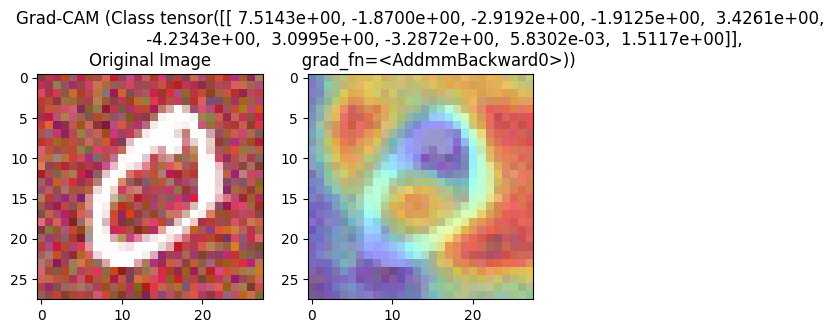

In [8]:
# Resize the heatmap to match original image size
heatmap_resized = cv2.resize(heatmap, (28, 28))

# Display the image and heatmap side-by-side
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].set_title("Original Image")

# 'jet' color map turns 0-1 into Blue-to-Red
ax[1].imshow(img, alpha=0.6) # Show original image faintly
ax[1].imshow(heatmap_resized, cmap='jet', alpha=0.4) # Overlay heatmap
ax[1].set_title(f"Grad-CAM (Class {prediction})")
plt.show()

In [ ]:
def generate_all_heatmaps():
    """Generate and save Grad-CAM heatmaps for all Colored-MNIST images.

    Saves blended (original + heatmap) images into:
      task3/heatmaps/train/ and task3/heatmaps/test/
    preserving original filenames.

    Notes:
    - Reuses the model, preprocessing, and Grad-CAM style demonstrated above.
    - Clears model gradients, plus stored activations/gradients, before each image.
    """
    # Input folders (relative to task3/ notebook directory, matching earlier cells)
    splits = {
        "train": "../task0/outputs/colored-mnist/train/images",
        "test": "../task0/outputs/colored-mnist/test/images",
    }
    
    # Output base folder (task3/heatmaps)
    out_base = os.path.join("heatmaps")
    os.makedirs(out_base, exist_ok=True)
    
    model.eval()
    model.to("cpu")
    
    # The layer used for Grad-CAM in this notebook
    last_conv_layer = get_conv_layer(model, "conv2")
    
    valid_exts = {".png", ".jpg", ".jpeg", ".bmp"}
    
    for split, in_dir in splits.items():
        out_dir = os.path.join(out_base, split)
        os.makedirs(out_dir, exist_ok=True)
        
        if not os.path.isdir(in_dir):
            raise FileNotFoundError(f"Input directory not found: {in_dir}")
        
        filenames = sorted(os.listdir(in_dir))
        for fname in filenames:
            ext = os.path.splitext(fname)[1].lower()
            if ext not in valid_exts:
                continue
            
            img_path = os.path.join(in_dir, fname)
            out_path = os.path.join(out_dir, fname)
            
            # Clear any state from previous image
            model.zero_grad(set_to_none=True)
            activations.clear()
            gradients.clear()
            torch.set_grad_enabled(True)
            
            # Hooks (attached per-image to avoid any cross-image interference)
            activations_hook = last_conv_layer.register_forward_hook(save_activations)
            gradients_hook = last_conv_layer.register_full_backward_hook(save_gradient)
            try:
                img, img_tensor = preprocess_image(img_path)
                img_tensor = img_tensor.to("cpu")
                
                # Forward + backward for predicted class
                prediction = model(img_tensor)
                score = prediction[0].max()
                score.backward()
                
                if len(activations) == 0 or len(gradients) == 0:
                    raise RuntimeError("Grad-CAM hooks did not capture activations/gradients.")
                
                # Grad-CAM (same steps/style as notebook)
                weights = np.mean(gradients[0], axis=(1, 2))
                heatmap = np.zeros(activations[0].shape[1:], dtype=np.float32)
                for i, w in enumerate(weights):
                    heatmap += w * activations[0][i]
                heatmap = np.maximum(heatmap, 0)
                if np.max(heatmap) != 0:
                    heatmap /= np.max(heatmap)
                
                # Resize to 28x28 (Colored MNIST) and blend with original image
                heatmap_resized = cv2.resize(heatmap, (28, 28))
                heatmap_uint8 = np.uint8(255 * heatmap_resized)
                heatmap_color_bgr = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
                heatmap_color_rgb = cv2.cvtColor(heatmap_color_bgr, cv2.COLOR_BGR2RGB)
                original_rgb = np.array(img, dtype=np.uint8)
                blended = cv2.addWeighted(original_rgb, 0.6, heatmap_color_rgb, 0.4, 0)
                Image.fromarray(blended).save(out_path)
            finally:
                # Always remove hooks and clear any stored state
                activations_hook.remove()
                gradients_hook.remove()
                model.zero_grad(set_to_none=True)
                activations.clear()
                gradients.clear()
                torch.set_grad_enabled(False)

# generate_all_heatmaps()

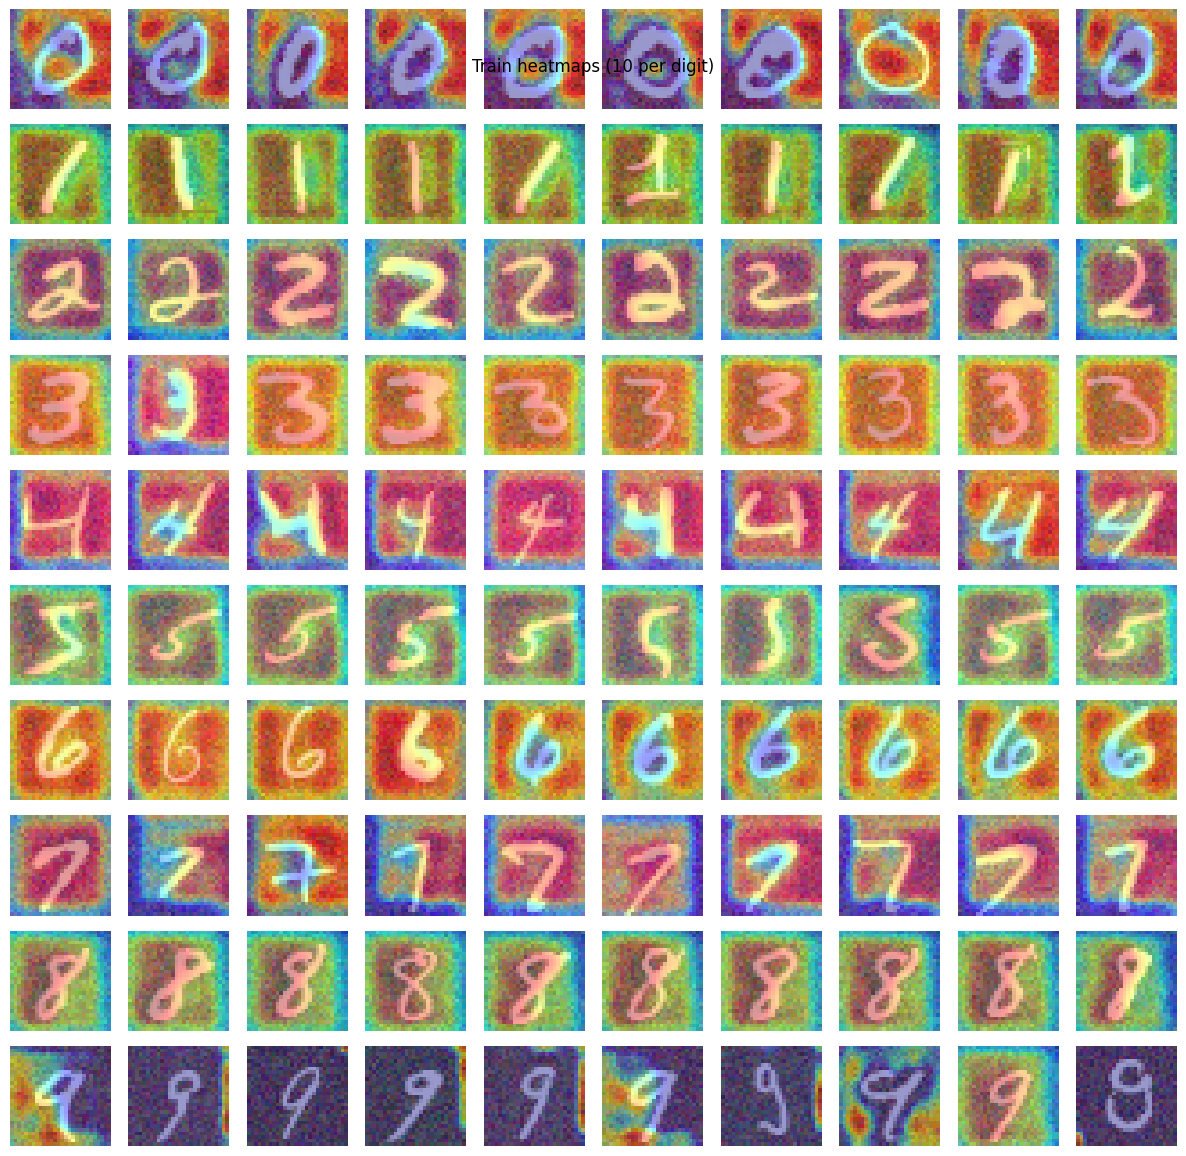

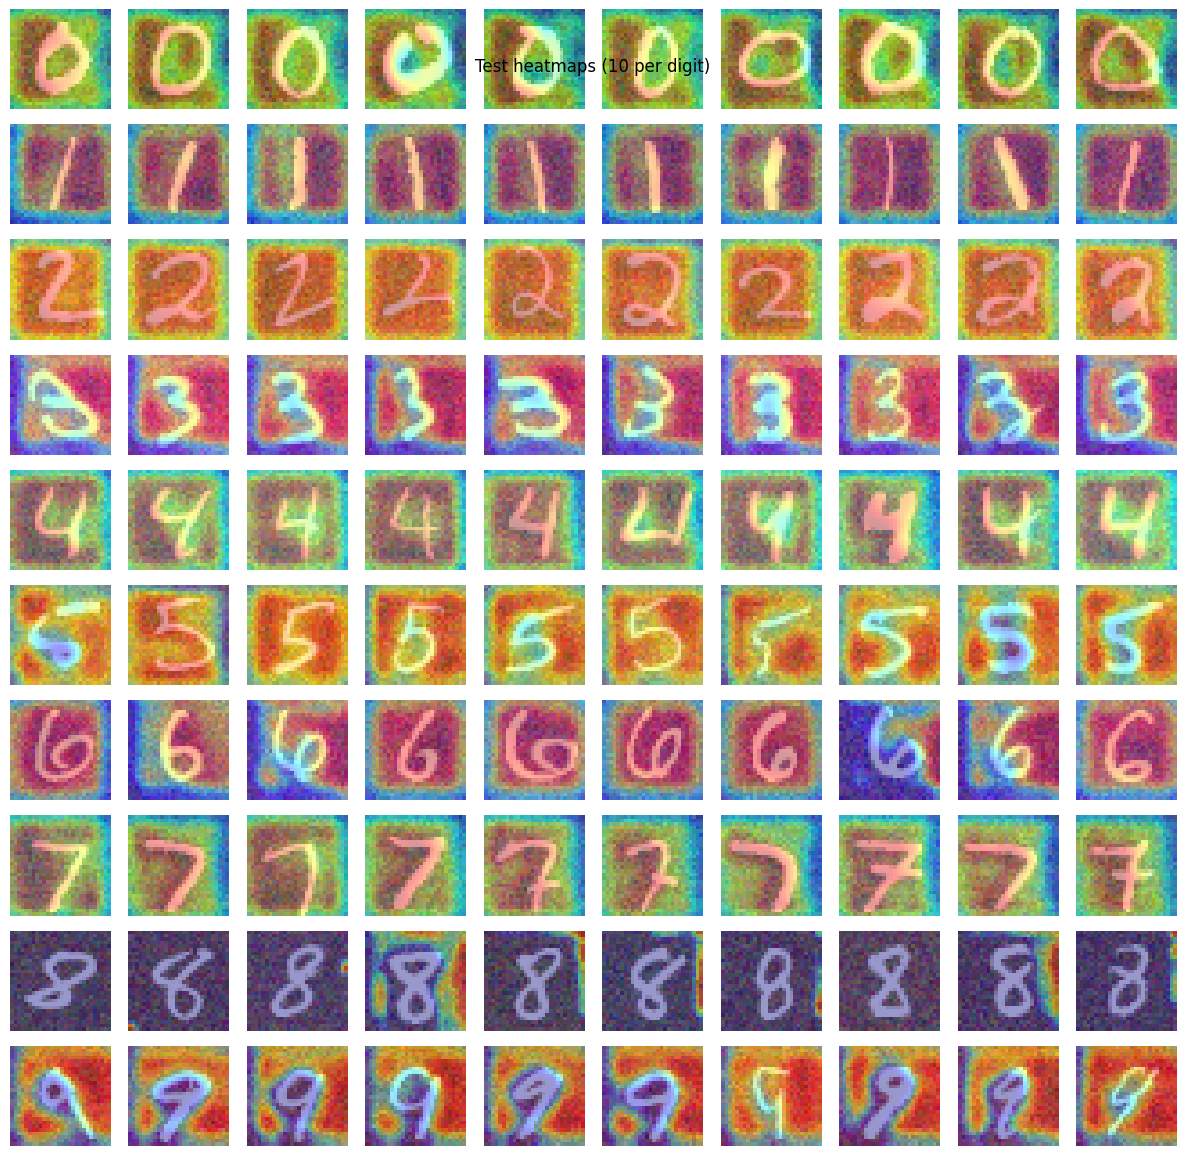

In [14]:
import re
from collections import defaultdict

def _label_from_filename(fname: str):
    """Extract digit label from filenames like 00001_0.png -> 0."""
    m = re.search(r"_(\d)\.[a-zA-Z0-9]+$", fname)
    if not m:
        return None
    return int(m.group(1))

def show_10x10_digit_grid(image_dir: str, title: str = "", max_per_digit: int = 10):
    """Show a 10x10 grid: rows=digits 0-9, cols=examples."""
    if not os.path.isdir(image_dir):
        raise FileNotFoundError(f"Directory not found: {image_dir}")

    by_digit = defaultdict(list)
    for fname in sorted(os.listdir(image_dir)):
        label = _label_from_filename(fname)
        if label is None or not (0 <= label <= 9):
            continue
        by_digit[label].append(fname)

    fig, axes = plt.subplots(10, 10, figsize=(12, 12))
    if title:
        fig.suptitle(title, y=0.92)

    for digit in range(10):
        samples = by_digit.get(digit, [])[:max_per_digit]
        for j in range(10):
            ax = axes[digit, j]
            ax.axis("off")
            if j < len(samples):
                img_path = os.path.join(image_dir, samples[j])
                img = Image.open(img_path).convert("RGB")
                ax.imshow(np.array(img))
            if j == 0:
                ax.set_ylabel(str(digit), rotation=0, labelpad=12, va="center")

    plt.tight_layout()
    plt.show()

# Heatmaps (generated by generate_all_heatmaps())
show_10x10_digit_grid("heatmaps/train", title="Train heatmaps (10 per digit)")
show_10x10_digit_grid("heatmaps/test", title="Test heatmaps (10 per digit)")